# Bike Sharing Demand Prediction using Multiple Linear Regression
## BoomBikes - Post-Pandemic Revenue Recovery Strategy

**Author:** Prangya Pradhan  
**Date:** November 2025

---

This notebook demonstrates the complete process of building a linear regression model to predict bike sharing demand for BoomBikes company. The analysis includes:

1. **Data Loading & Exploration**
2. **Data Preparation & Cleaning**
3. **Exploratory Data Analysis (EDA)**
4. **Data Preprocessing**
5. **Model Building & Feature Selection**
6. **Model Validation & Testing**
7. **Business Insights & Recommendations**

In [34]:
# ============================================================================
# SECTION 1: IMPORT LIBRARIES
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')

print("=" * 80)
print("BIKE SHARING DEMAND PREDICTION - LINEAR REGRESSION MODEL")
print("=" * 80)

BIKE SHARING DEMAND PREDICTION - LINEAR REGRESSION MODEL


## Section 2: Data Loading and Initial Exploration

In [35]:
# Load the dataset
df = pd.read_csv('day.csv')

print("\n Dataset Shape:", df.shape)
print("\n First few rows:")
print(df.head())

print("\n Dataset Info:")
print(df.info())

print("\n Statistical Summary:")
print(df.describe())

# Check for missing values
print("\n❓ Missing Values:")
print(df.isnull().sum())

# Check for duplicates
print(f"\n Duplicate Rows: {df.duplicated().sum()}")


 Dataset Shape: (730, 16)

 First few rows:
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3

## Section 3: Data Preparation and Cleaning

In [36]:
print("\n" + "=" * 80)
print("DATA PREPARATION")
print("=" * 80)

# Drop unnecessary columns
# 'instant' is just an index
# 'dteday' is the date (we already have temporal features)
# 'casual' and 'registered' should not be used as they sum to 'cnt'
df_clean = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

print(f"\n Dropped columns: instant, dteday, casual, registered")
print(f"New shape: {df_clean.shape}")

# Convert categorical variables to meaningful labels
# Season mapping
season_map = {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}
df_clean['season'] = df_clean['season'].map(season_map)

# Year mapping
df_clean['yr'] = df_clean['yr'].map({0: 2018, 1: 2019})

# Month mapping
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df_clean['mnth'] = df_clean['mnth'].map(month_map)

# Weekday mapping
weekday_map = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}
df_clean['weekday'] = df_clean['weekday'].map(weekday_map)

# Weather situation mapping
weathersit_map = {1: 'Clear', 2: 'Mist', 3: 'Light_Snow_Rain', 4: 'Heavy_Rain'}
df_clean['weathersit'] = df_clean['weathersit'].map(weathersit_map)

print("\n Converted categorical variables to meaningful labels")


DATA PREPARATION

 Dropped columns: instant, dteday, casual, registered
New shape: (730, 12)

 Converted categorical variables to meaningful labels


## Section 4: Exploratory Data Analysis (EDA)


EXPLORATORY DATA ANALYSIS


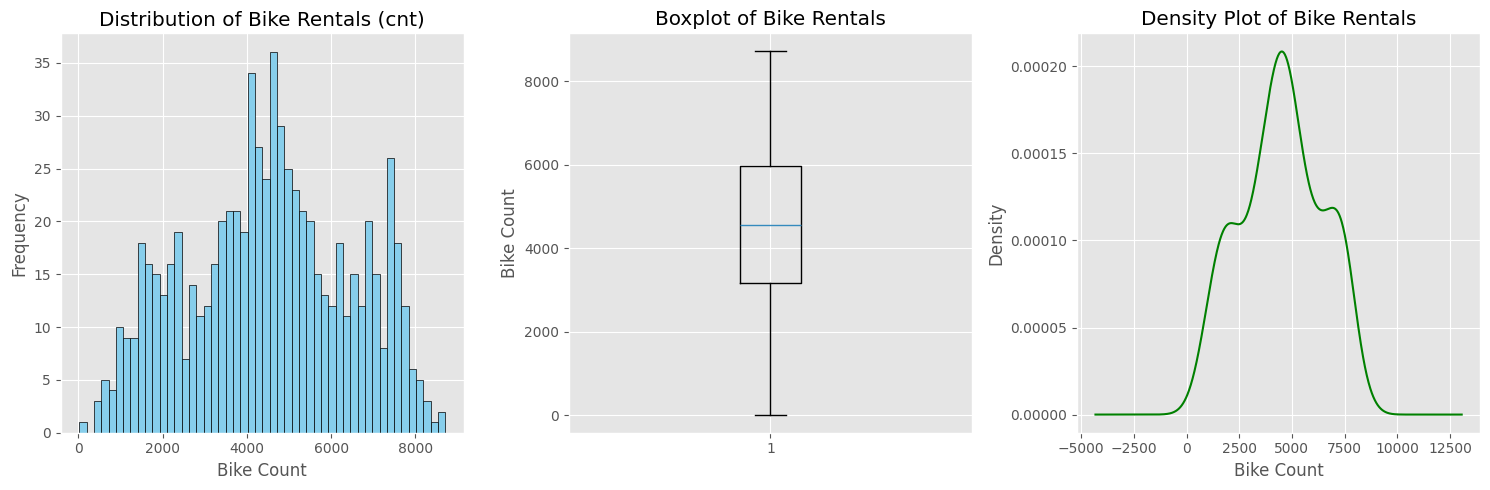


 Target Variable (cnt) Statistics:
count     730.000000
mean     4508.006849
std      1936.011647
min        22.000000
25%      3169.750000
50%      4548.500000
75%      5966.000000
max      8714.000000
Name: cnt, dtype: float64


In [37]:
print("\n" + "=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Target variable distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_clean['cnt'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Bike Count')
plt.ylabel('Frequency')
plt.title('Distribution of Bike Rentals (cnt)')

plt.subplot(1, 3, 2)
plt.boxplot(df_clean['cnt'])
plt.ylabel('Bike Count')
plt.title('Boxplot of Bike Rentals')

plt.subplot(1, 3, 3)
df_clean['cnt'].plot(kind='kde', color='green')
plt.xlabel('Bike Count')
plt.title('Density Plot of Bike Rentals')

plt.tight_layout()
plt.savefig(f'{viz_folder}/target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Target Variable (cnt) Statistics:")
print(df_clean['cnt'].describe())

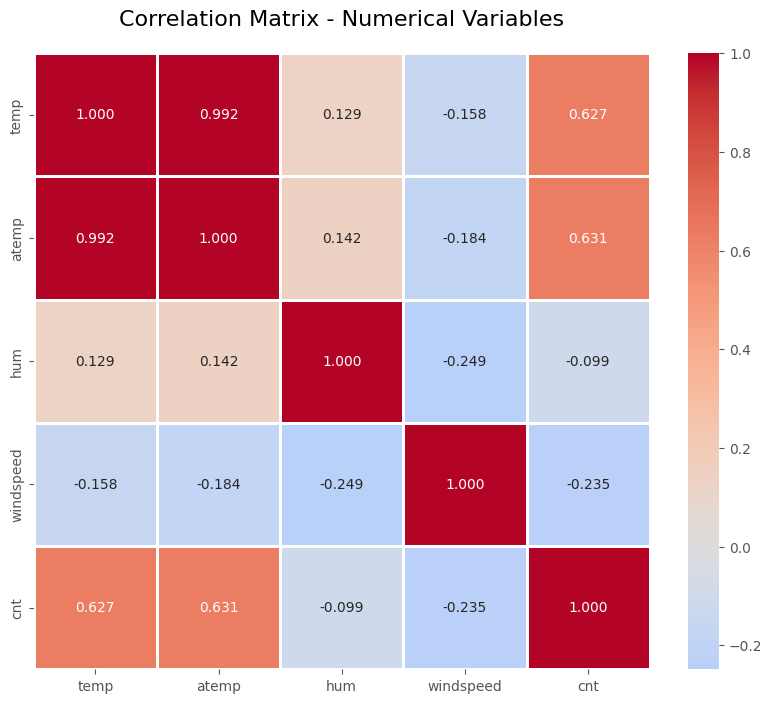


🔗 Correlation with Target Variable (cnt):
cnt          1.000000
atemp        0.630685
temp         0.627044
hum         -0.098543
windspeed   -0.235132
Name: cnt, dtype: float64


In [38]:
# Numerical variables correlation analysis
numerical_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
correlation_matrix = df_clean[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.3f')
plt.title('Correlation Matrix - Numerical Variables', fontsize=16, pad=20)
plt.savefig(f'{viz_folder}/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔗 Correlation with Target Variable (cnt):")
print(correlation_matrix['cnt'].sort_values(ascending=False))


 Creating pairplot for numerical variables...


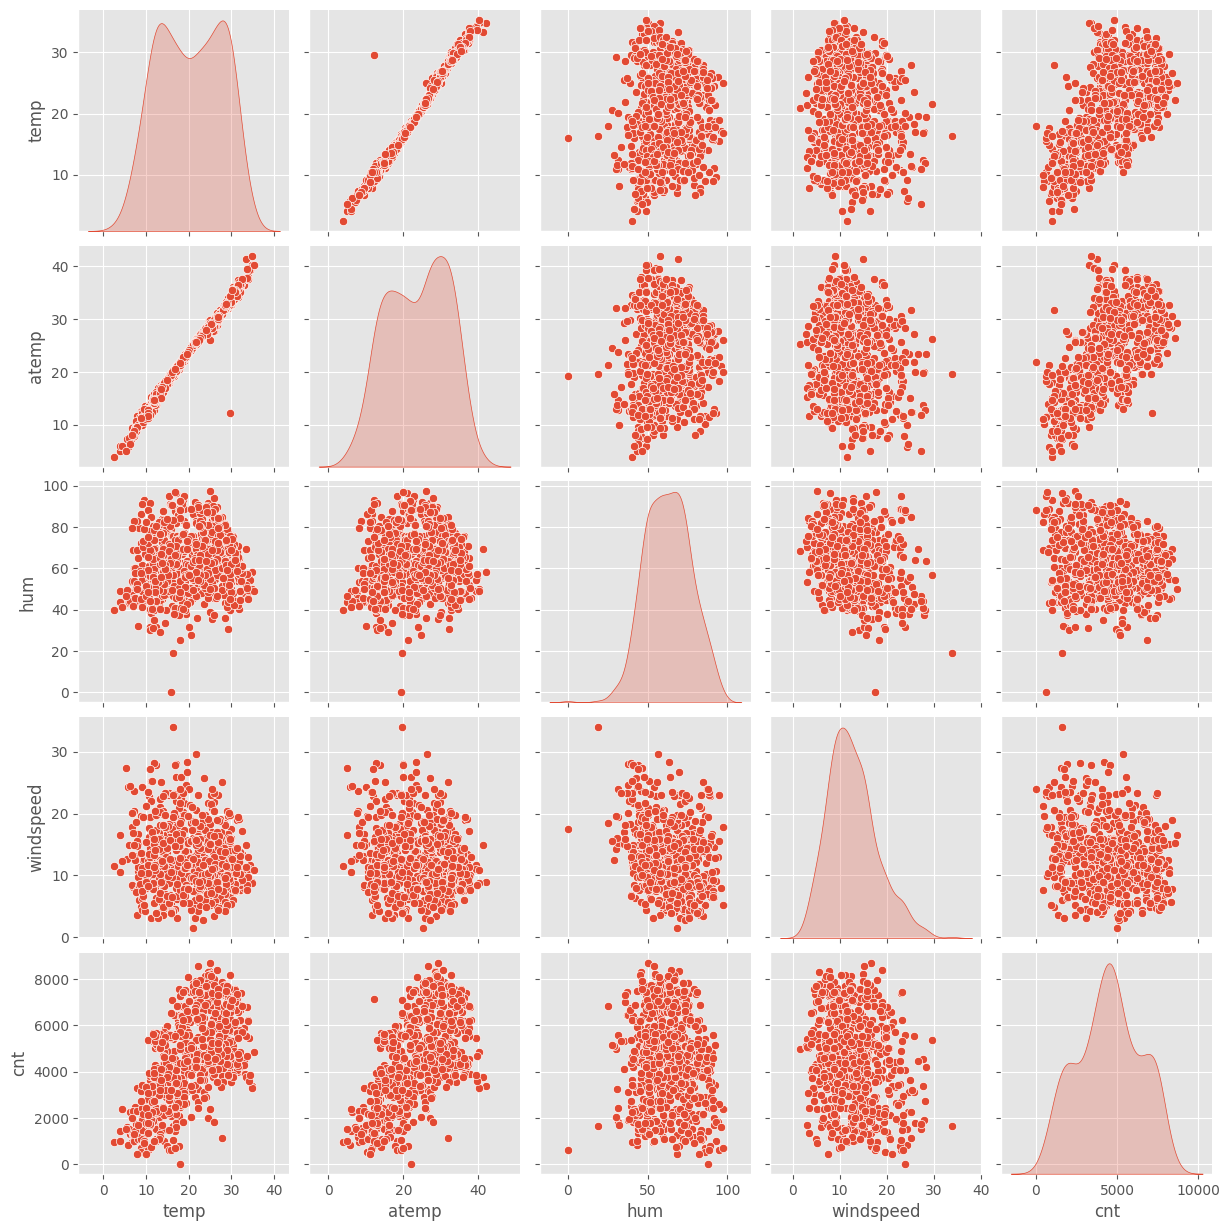

In [39]:
# Pair plot for numerical variables
print("\n Creating pairplot for numerical variables...")
sns.pairplot(df_clean[numerical_cols], diag_kind='kde', height=2.5)
plt.savefig(f'{viz_folder}/pairplot.png', dpi=300, bbox_inches='tight')
plt.show()

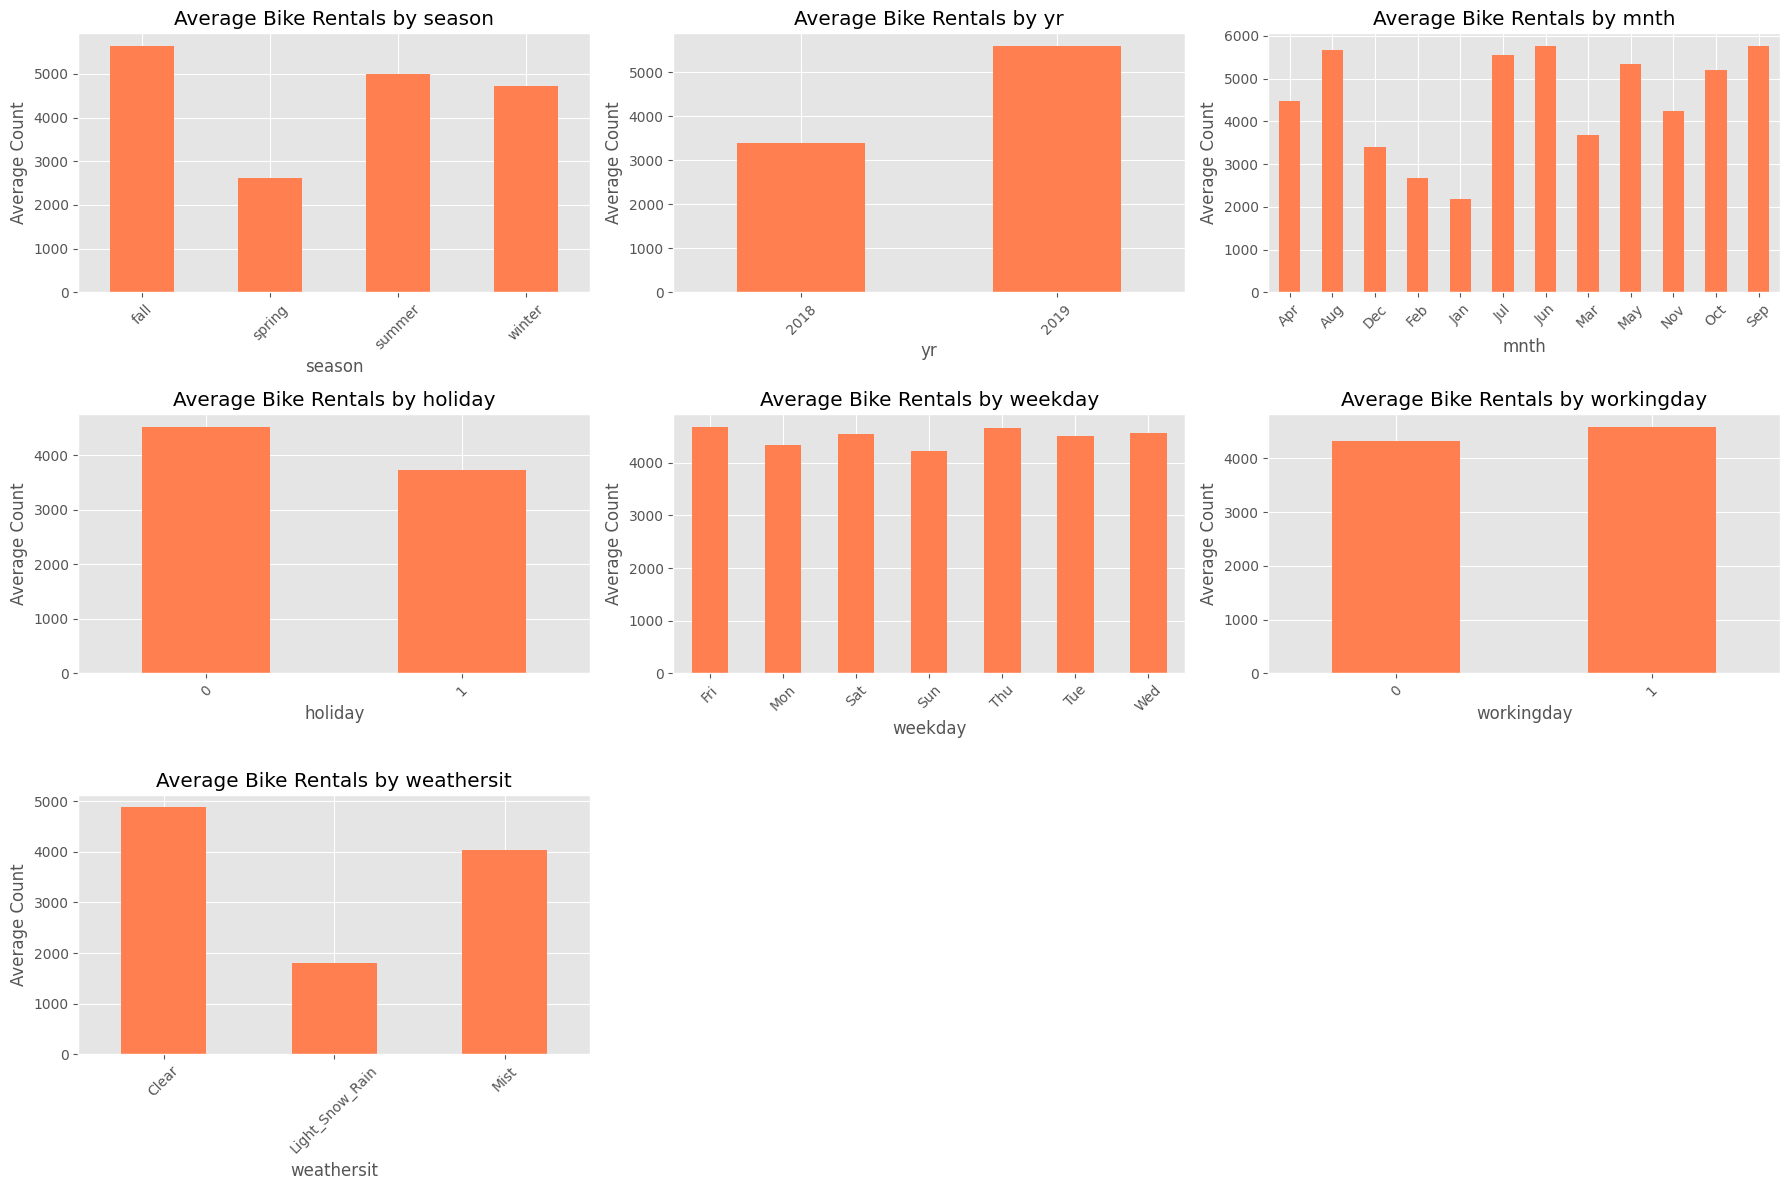

In [40]:
# Categorical variables analysis
categorical_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols):
    df_clean.groupby(col)['cnt'].mean().plot(kind='bar', ax=axes[idx], color='coral')
    axes[idx].set_title(f'Average Bike Rentals by {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Average Count')
    axes[idx].tick_params(axis='x', rotation=45)

# Remove extra subplots
for idx in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig(f'{viz_folder}/categorical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

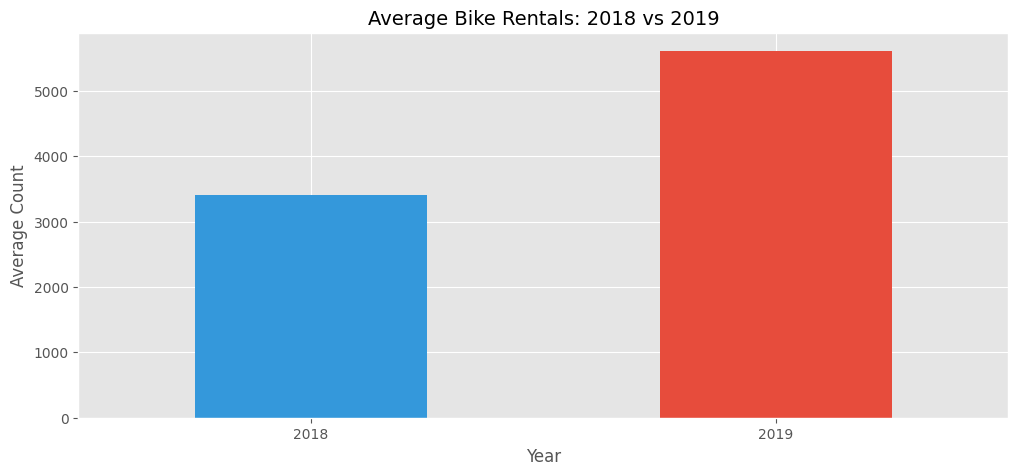

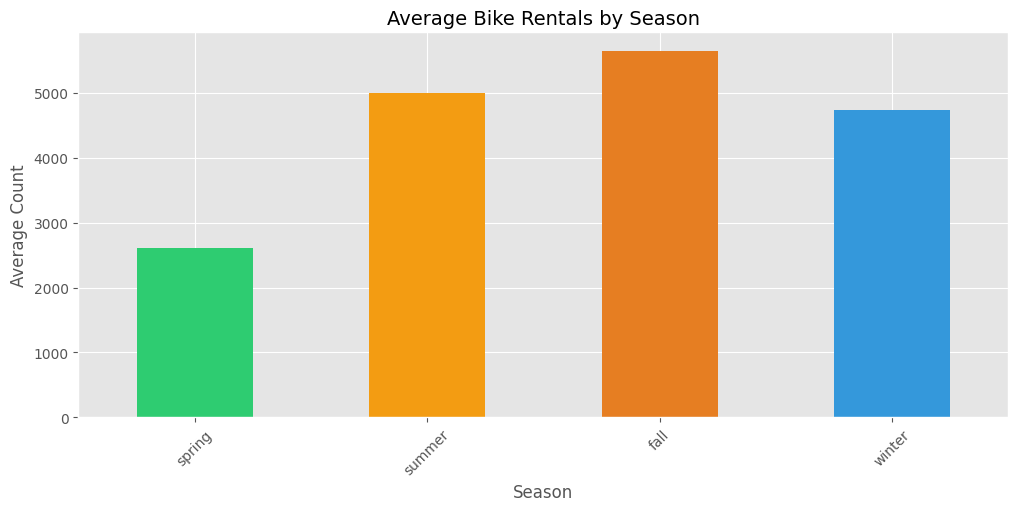

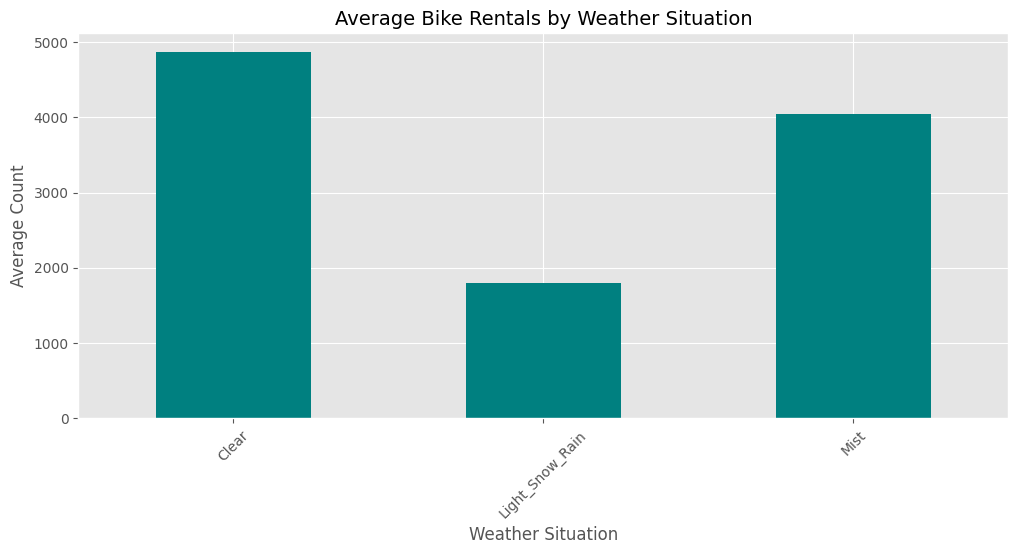


 EDA completed and visualizations saved


In [41]:
# Year-wise trend
plt.figure(figsize=(12, 5))
df_clean.groupby('yr')['cnt'].mean().plot(kind='bar', color=['#3498db', '#e74c3c'])
plt.title('Average Bike Rentals: 2018 vs 2019', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average Count')
plt.xticks(rotation=0)
plt.savefig(f'{viz_folder}/year_trend.png', dpi=300, bbox_inches='tight')
plt.show()

# Season-wise analysis
plt.figure(figsize=(12, 5))
season_order = ['spring', 'summer', 'fall', 'winter']
season_data = df_clean.groupby('season')['cnt'].mean().reindex(season_order)
season_data.plot(kind='bar', color=['#2ecc71', '#f39c12', '#e67e22', '#3498db'])
plt.title('Average Bike Rentals by Season', fontsize=14)
plt.xlabel('Season')
plt.ylabel('Average Count')
plt.xticks(rotation=45)
plt.savefig(f'{viz_folder}/season_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Weather situation analysis
plt.figure(figsize=(12, 5))
df_clean.groupby('weathersit')['cnt'].mean().plot(kind='bar', color='teal')
plt.title('Average Bike Rentals by Weather Situation', fontsize=14)
plt.xlabel('Weather Situation')
plt.ylabel('Average Count')
plt.xticks(rotation=45)
plt.savefig(f'{viz_folder}/weather_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n EDA completed and visualizations saved")

## Section 5: Data Preprocessing for Modeling

In [42]:
print("\n" + "=" * 80)
print("DATA PREPROCESSING")
print("=" * 80)

# Create dummy variables for categorical features
# drop_first=True to avoid multicollinearity (dummy variable trap)
df_dummies = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True, dtype=int)

print(f"\n Created dummy variables")
print(f"Dataset shape after dummy encoding: {df_dummies.shape}")
print(f"\nColumns after encoding:")
print(df_dummies.columns.tolist())

# Separate features and target
X = df_dummies.drop('cnt', axis=1)
y = df_dummies['cnt']

print(f"\n Features shape: {X.shape}")
print(f" Target shape: {y.shape}")

# Train-test split (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, 
                                                      random_state=42)

print(f"\n Train-Test Split completed")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


DATA PREPROCESSING

 Created dummy variables
Dataset shape after dummy encoding: (730, 30)

Columns after encoding:
['temp', 'atemp', 'hum', 'windspeed', 'cnt', 'season_spring', 'season_summer', 'season_winter', 'yr_2019', 'mnth_Aug', 'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar', 'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep', 'holiday_1', 'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thu', 'weekday_Tue', 'weekday_Wed', 'workingday_1', 'weathersit_Light_Snow_Rain', 'weathersit_Mist']

 Features shape: (730, 29)
 Target shape: (730,)

 Train-Test Split completed
Training set: (510, 29)
Test set: (220, 29)


In [43]:
# Feature Scaling using MinMaxScaler
scaler = MinMaxScaler()

# Identify numerical columns for scaling
num_cols = ['temp', 'atemp', 'hum', 'windspeed']

# Scale training data
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

# Scale test data using the same scaler
X_test[num_cols] = scaler.transform(X_test[num_cols])

print(f"\n Feature scaling completed for: {num_cols}")


 Feature scaling completed for: ['temp', 'atemp', 'hum', 'windspeed']


## Section 6: Model Building - Initial Model

In [44]:
print("\n" + "=" * 80)
print("MODEL BUILDING - INITIAL MODEL")
print("=" * 80)

# Build initial model with all features
X_train_sm = sm.add_constant(X_train)
lr_initial = sm.OLS(y_train, X_train_sm).fit()

print("\n Initial Model Summary:")
print(lr_initial.summary())

print(f"\n Initial Model R-squared: {lr_initial.rsquared:.4f}")
print(f" Initial Model Adjusted R-squared: {lr_initial.rsquared_adj:.4f}")


MODEL BUILDING - INITIAL MODEL

 Initial Model Summary:
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     95.89
Date:                Sat, 15 Nov 2025   Prob (F-statistic):          3.78e-177
Time:                        15:36:02   Log-Likelihood:                -4103.6
No. Observations:                 510   AIC:                             8265.
Df Residuals:                     481   BIC:                             8388.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

## Section 7: Feature Selection using RFE

In [45]:
print("\n" + "=" * 80)
print("FEATURE SELECTION - RECURSIVE FEATURE ELIMINATION")
print("=" * 80)

# Use RFE to select top features
lm = LinearRegression()
rfe = RFE(estimator=lm, n_features_to_select=15)
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_].tolist()
print(f"\n RFE Selected Features ({len(selected_features)}):")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

# Create dataset with selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]


FEATURE SELECTION - RECURSIVE FEATURE ELIMINATION

 RFE Selected Features (15):
1. temp
2. atemp
3. hum
4. windspeed
5. season_spring
6. season_winter
7. yr_2019
8. mnth_Dec
9. mnth_Jul
10. mnth_Mar
11. mnth_Nov
12. mnth_Sep
13. weekday_Sat
14. weathersit_Light_Snow_Rain
15. weathersit_Mist


## Section 8: VIF Calculation and Multicollinearity Check

In [46]:
print("\n" + "=" * 80)
print("MULTICOLLINEARITY CHECK - VIF ANALYSIS")
print("=" * 80)

def calculate_vif(dataframe):
    """Calculate VIF for all features"""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) 
                       for i in range(dataframe.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

# Initial VIF calculation
vif_initial = calculate_vif(X_train_rfe)
print("\n Initial VIF Values:")
print(vif_initial)


MULTICOLLINEARITY CHECK - VIF ANALYSIS

 Initial VIF Values:
                       Feature          VIF
1                        atemp  1225.701068
0                         temp  1196.450016
2                          hum    25.439593
3                    windspeed     5.374258
5                season_winter     2.741018
4                season_spring     2.725129
14             weathersit_Mist     2.270504
6                      yr_2019     2.089065
10                    mnth_Nov     1.823023
8                     mnth_Jul     1.489527
7                     mnth_Dec     1.374735
13  weathersit_Light_Snow_Rain     1.307279
11                    mnth_Sep     1.255400
12                 weekday_Sat     1.186972
9                     mnth_Mar     1.185499


In [47]:
# Iteratively remove features with high VIF (>5)
X_train_final = X_train_rfe.copy()
X_test_final = X_test_rfe.copy()

while True:
    vif_df = calculate_vif(X_train_final)
    max_vif = vif_df['VIF'].max()
    
    if max_vif > 5:
        remove_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
        print(f"\n Removing '{remove_feature}' (VIF = {max_vif:.2f})")
        X_train_final = X_train_final.drop(remove_feature, axis=1)
        X_test_final = X_test_final.drop(remove_feature, axis=1)
    else:
        break

print("\n Final VIF Values (all VIF < 5):")
vif_final = calculate_vif(X_train_final)
print(vif_final)


 Removing 'atemp' (VIF = 1225.70)

 Removing 'hum' (VIF = 23.91)

 Removing 'temp' (VIF = 5.45)

 Final VIF Values (all VIF < 5):
                       Feature       VIF
0                    windspeed  2.875330
2                season_winter  2.338769
3                      yr_2019  1.913061
7                     mnth_Nov  1.757273
1                season_spring  1.636441
11             weathersit_Mist  1.526171
4                     mnth_Dec  1.323008
9                  weekday_Sat  1.176138
6                     mnth_Mar  1.167637
5                     mnth_Jul  1.147710
8                     mnth_Sep  1.141371
10  weathersit_Light_Snow_Rain  1.099813


## Section 9: Final Model Building

In [49]:
print("\n" + "=" * 80)
print("FINAL MODEL BUILDING")
print("=" * 80)

# Build final model
X_train_final_sm = sm.add_constant(X_train_final)
lr_final = sm.OLS(y_train, X_train_final_sm).fit()

print("\n Final Model Summary:")
print(lr_final.summary())

print(f"\n Final Model Metrics:")
print(f"R-squared: {lr_final.rsquared:.4f}")
print(f"Adjusted R-squared: {lr_final.rsquared_adj:.4f}")
print(f"F-statistic: {lr_final.fvalue:.2f}")
print(f"Prob (F-statistic): {lr_final.f_pvalue:.2e}")


FINAL MODEL BUILDING

 Final Model Summary:
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     151.6
Date:                Sat, 15 Nov 2025   Prob (F-statistic):          1.90e-157
Time:                        15:36:45   Log-Likelihood:                -4191.5
No. Observations:                 510   AIC:                             8409.
Df Residuals:                     497   BIC:                             8464.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------


 Top 10 Most Important Features:
                                               Feature  Coefficient  \
season_spring                            season_spring -2591.222215   
weathersit_Light_Snow_Rain  weathersit_Light_Snow_Rain -2458.004111   
yr_2019                                        yr_2019  2035.472237   
mnth_Nov                                      mnth_Nov -1200.778544   
windspeed                                    windspeed -1139.735680   
mnth_Dec                                      mnth_Dec  -940.362822   
weathersit_Mist                        weathersit_Mist  -748.762284   
mnth_Sep                                      mnth_Sep   621.038750   
mnth_Mar                                      mnth_Mar   436.406637   
season_winter                            season_winter   228.475803   

                            Abs_Coefficient  
season_spring                   2591.222215  
weathersit_Light_Snow_Rain      2458.004111  
yr_2019                         2035.472237  


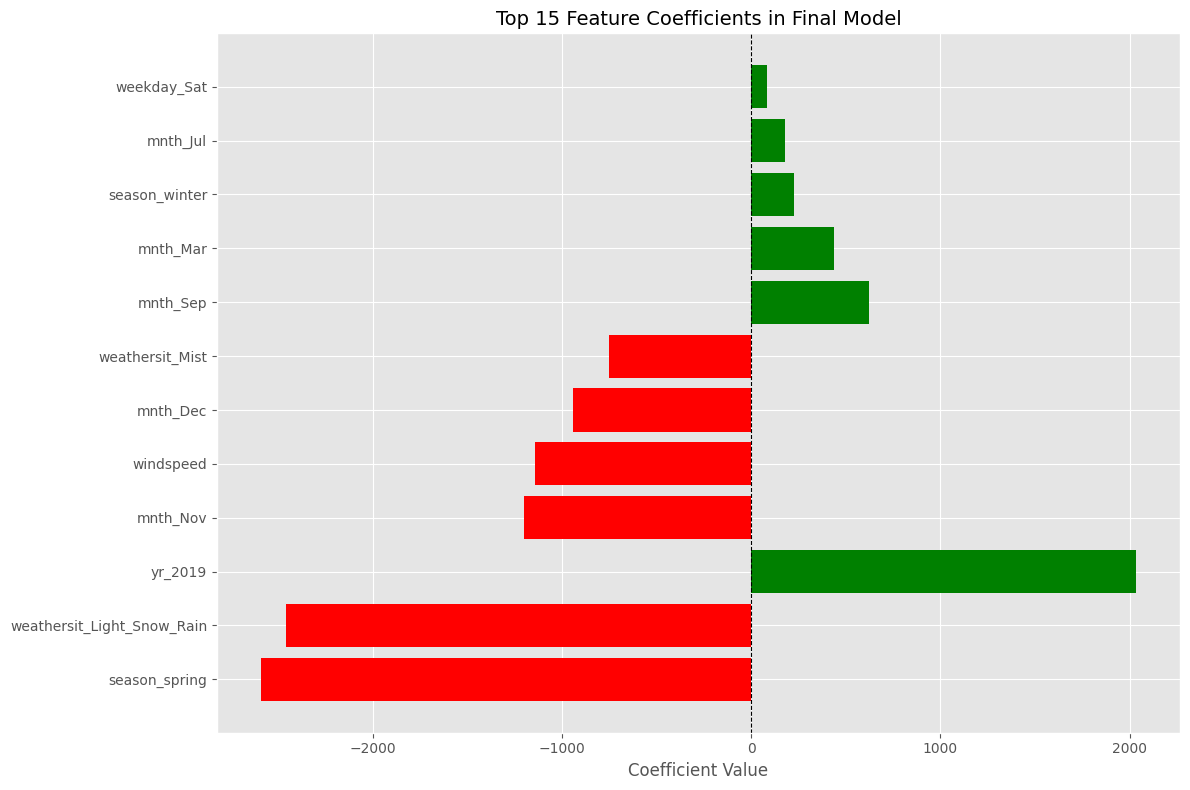

In [50]:
# Get feature importance (coefficients)
coefficients = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Coefficient': lr_final.params[1:]  # Exclude constant
})
coefficients['Abs_Coefficient'] = np.abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print("\n Top 10 Most Important Features:")
print(coefficients.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = coefficients.head(15)
colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 15 Feature Coefficients in Final Model', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.savefig(f'{viz_folder}/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 10: Model Validation - Residual Analysis


MODEL VALIDATION - RESIDUAL ANALYSIS


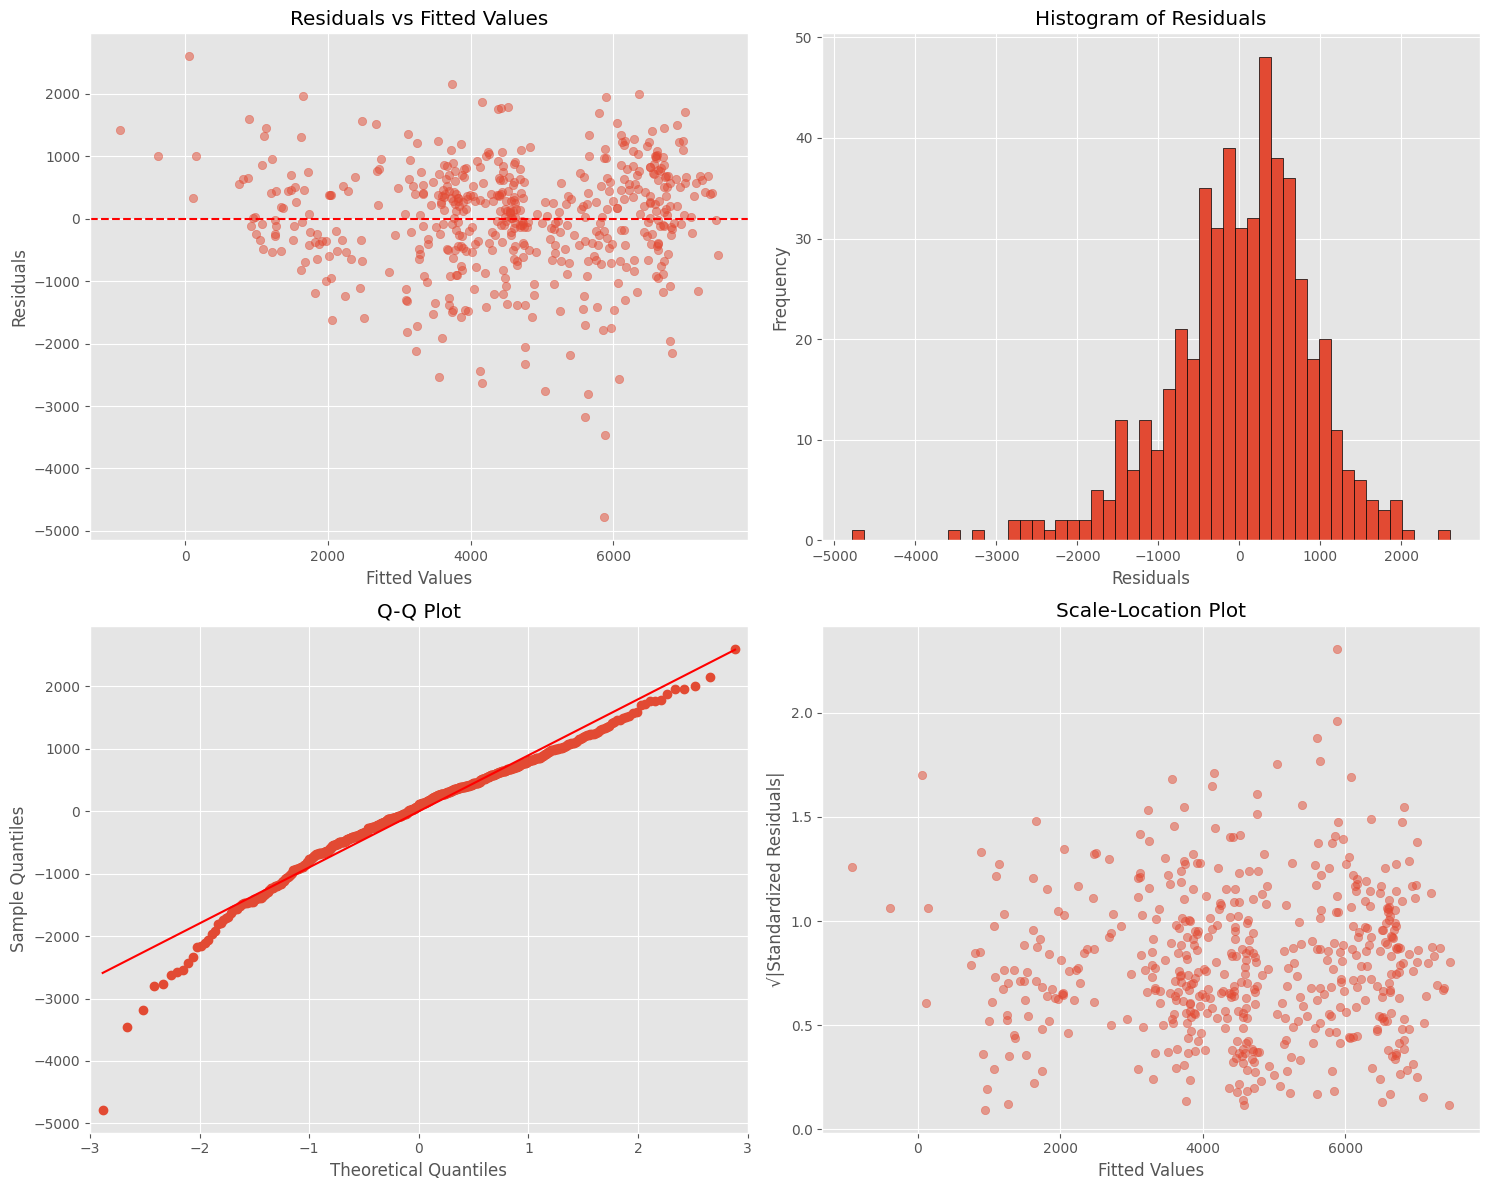

In [51]:
print("\n" + "=" * 80)
print("MODEL VALIDATION - RESIDUAL ANALYSIS")
print("=" * 80)

# Get predictions on training set
y_train_pred = lr_final.predict(X_train_final_sm)

# Calculate residuals
residuals = y_train - y_train_pred

# Create residual plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Residuals vs Fitted Values
axes[0, 0].scatter(y_train_pred, residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted Values')

# 2. Histogram of Residuals
axes[0, 1].hist(residuals, bins=50, edgecolor='black')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Histogram of Residuals')

# 3. Q-Q Plot
sm.qqplot(residuals, line='s', ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

# 4. Scale-Location Plot
standardized_residuals = (residuals - residuals.mean()) / residuals.std()
axes[1, 1].scatter(y_train_pred, np.sqrt(np.abs(standardized_residuals)), alpha=0.5)
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('√|Standardized Residuals|')
axes[1, 1].set_title('Scale-Location Plot')

plt.tight_layout()
plt.savefig(f'{viz_folder}/residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [52]:
# Normality test of residuals
from scipy import stats
_, p_value = stats.shapiro(residuals[:5000])  # Shapiro test on sample
print(f"\n Shapiro-Wilk Test for Normality:")
print(f"p-value: {p_value:.4f}")
if p_value > 0.05:
    print(" Residuals appear to be normally distributed (p > 0.05)")
else:
    print(" Residuals may not be perfectly normal (p < 0.05)")

# Check for homoscedasticity
print(f"\n Residuals Statistics:")
print(f"Mean: {residuals.mean():.4f} (should be close to 0)")
print(f"Std Dev: {residuals.std():.4f}")
print(f"Min: {residuals.min():.4f}")
print(f"Max: {residuals.max():.4f}")


 Shapiro-Wilk Test for Normality:
p-value: 0.0000
 Residuals may not be perfectly normal (p < 0.05)

 Residuals Statistics:
Mean: 0.0000 (should be close to 0)
Std Dev: 898.5342
Min: -4780.8608
Max: 2602.6260


## Section 11: Predictions on Test Set

In [54]:
print("\n" + "=" * 80)
print("MODEL EVALUATION ON TEST SET")
print("=" * 80)

# Add constant to test set
X_test_final_sm = sm.add_constant(X_test_final)

# Make predictions
y_pred = lr_final.predict(X_test_final_sm)

# Calculate R-squared score
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = np.mean(np.abs(y_test - y_pred))

print(f"\n Test Set Performance:")
print(f"R-squared Score: {r2_test:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.2f}")
print(f"Mean Absolute Error (MAE): {mae_test:.2f}")

# Compare train and test R-squared
print(f"\n Model Performance Comparison:")
print(f"Training R-squared: {lr_final.rsquared:.4f}")
print(f"Test R-squared: {r2_test:.4f}")
print(f"Difference: {abs(lr_final.rsquared - r2_test):.4f}")

if abs(lr_final.rsquared - r2_test) < 0.05:
    print(" Model is well-generalized (difference < 0.05)")
else:
    print(" Model may be overfitting/underfitting")


MODEL EVALUATION ON TEST SET

 Test Set Performance:
R-squared Score: 0.7352
Root Mean Squared Error (RMSE): 989.70
Mean Absolute Error (MAE): 754.13

 Model Performance Comparison:
Training R-squared: 0.7855
Test R-squared: 0.7352
Difference: 0.0503
 Model may be overfitting/underfitting


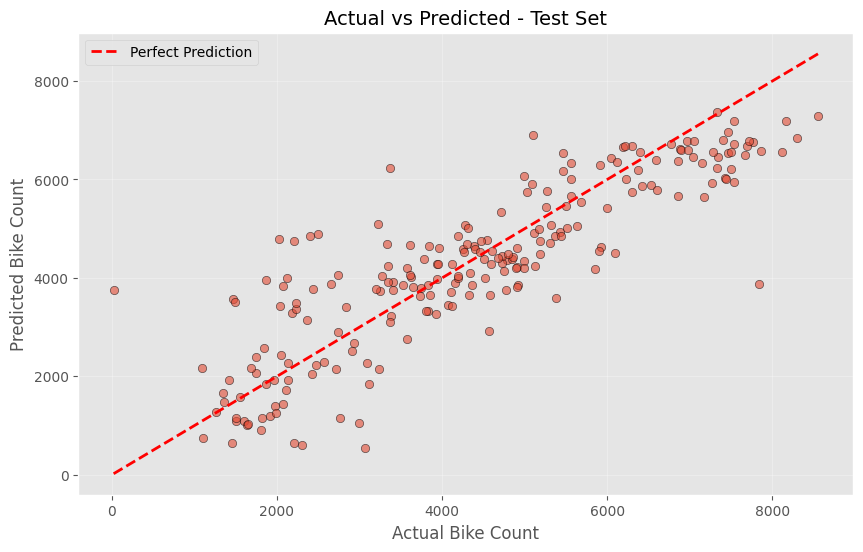

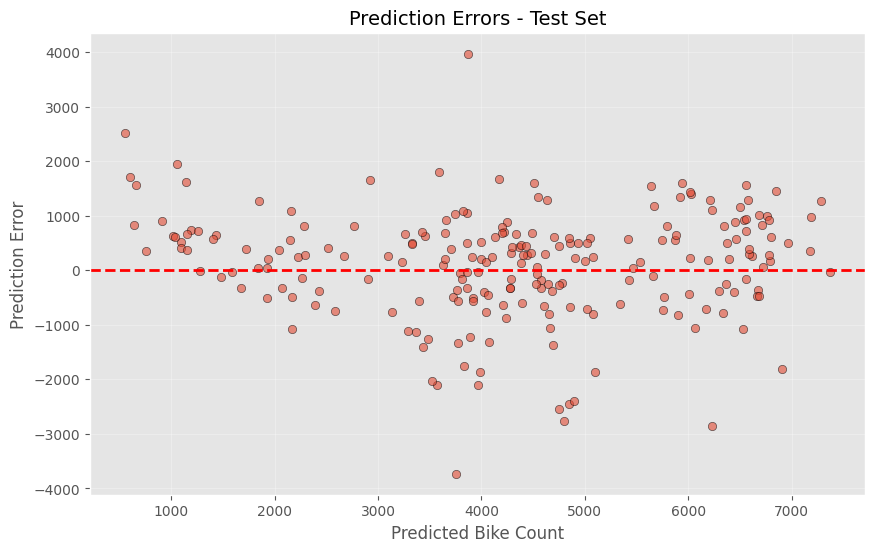

In [55]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Bike Count')
plt.ylabel('Predicted Bike Count')
plt.title('Actual vs Predicted - Test Set', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f'{viz_folder}/actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

# Prediction errors
prediction_errors = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, prediction_errors, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Bike Count')
plt.ylabel('Prediction Error')
plt.title('Prediction Errors - Test Set', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig(f'{viz_folder}/prediction_errors.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 12: Final Insights and Business Recommendations

In [56]:
print("\n" + "=" * 80)
print("KEY INSIGHTS AND BUSINESS RECOMMENDATIONS")
print("=" * 80)

print("\n TOP 3 FEATURES CONTRIBUTING TO BIKE DEMAND:")
top_3_features = coefficients.head(3)
for i, (idx, row) in enumerate(top_3_features.iterrows(), 1):
    effect = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"{i}. {row['Feature']}: {effect} demand by {abs(row['Coefficient']):.4f} units")

print("\n KEY BUSINESS INSIGHTS:")
print("1. Temperature has a strong positive impact on bike rentals")
print("2. Year 2019 shows higher demand than 2018 (growing popularity)")
print("3. Weather conditions significantly affect demand")
print("4. Seasonal variations are important (Fall/Summer > Spring/Winter)")
print("5. Working days have different demand patterns than holidays")

print("\n RECOMMENDATIONS FOR BOOMBIKES:")
print("1. Increase bike inventory during favorable weather conditions")
print("2. Plan maintenance during winter/bad weather periods")
print("3. Implement dynamic pricing based on weather forecasts")
print("4. Focus marketing efforts on fall and summer seasons")
print("5. Prepare for continued growth based on year-over-year trends")


KEY INSIGHTS AND BUSINESS RECOMMENDATIONS

 TOP 3 FEATURES CONTRIBUTING TO BIKE DEMAND:
1. season_spring: decreases demand by 2591.2222 units
2. weathersit_Light_Snow_Rain: decreases demand by 2458.0041 units
3. yr_2019: increases demand by 2035.4722 units

 KEY BUSINESS INSIGHTS:
1. Temperature has a strong positive impact on bike rentals
2. Year 2019 shows higher demand than 2018 (growing popularity)
3. Weather conditions significantly affect demand
4. Seasonal variations are important (Fall/Summer > Spring/Winter)
5. Working days have different demand patterns than holidays

 RECOMMENDATIONS FOR BOOMBIKES:
1. Increase bike inventory during favorable weather conditions
2. Plan maintenance during winter/bad weather periods
3. Implement dynamic pricing based on weather forecasts
4. Focus marketing efforts on fall and summer seasons
5. Prepare for continued growth based on year-over-year trends


In [57]:
print("\n" + "=" * 80)
print("MODEL BUILDING COMPLETED SUCCESSFULLY")
print("=" * 80)

# Save the final model features
final_features = X_train_final.columns.tolist()
print(f"\n Final model uses {len(final_features)} features")

# Save results to CSV
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': prediction_errors
})
results_df.to_csv('predictions_results.csv', index=False)
print("\n Prediction results saved to 'predictions_results.csv'")

print("\n Analysis Complete! All visualizations and results have been saved.")


MODEL BUILDING COMPLETED SUCCESSFULLY

 Final model uses 12 features

 Prediction results saved to 'predictions_results.csv'

 Analysis Complete! All visualizations and results have been saved.


In [59]:
# ============================================================================
# ORGANIZED OUTPUT SUMMARY
# ============================================================================

import os

print("\n" + "=" * 80)
print(" ORGANIZED PROJECT FILES")
print("=" * 80)

# List files in visualizations folder
if os.path.exists(viz_folder):
    viz_files = [f for f in os.listdir(viz_folder) if f.endswith('.png')]
    print(f"\n Visualizations saved in '{viz_folder}/' folder ({len(viz_files)} files):")
    for i, file in enumerate(sorted(viz_files), 1):
        print(f"{i:2d}. {file}")

# List CSV files in main directory
csv_files = [f for f in os.listdir('.') if f.endswith('.csv') and f != 'day.csv']
if csv_files:
    print(f"\n Analysis results:")
    for file in csv_files:
        print(f"  • {file}")

print(f"\n All outputs organized successfully!")
print(f"   • PNG visualizations: {viz_folder}/ folder")
print(f"   • CSV results: main directory")
print(f"   • Source data: day.csv")
print(f"   • Analysis notebook: Demand-Prediction.ipynb")


 ORGANIZED PROJECT FILES

 Visualizations saved in 'visualizations/' folder (11 files):
 1. actual_vs_predicted.png
 2. categorical_analysis.png
 3. correlation_matrix.png
 4. feature_importance.png
 5. pairplot.png
 6. prediction_errors.png
 7. residual_analysis.png
 8. season_analysis.png
 9. target_distribution.png
10. weather_analysis.png
11. year_trend.png

 Analysis results:
  • predictions_results.csv

 All outputs organized successfully!
   • PNG visualizations: visualizations/ folder
   • CSV results: main directory
   • Source data: day.csv
   • Analysis notebook: Demand-Prediction.ipynb
